In [1]:
! pip install WordCloud

     |████████████████████████████████| 371 kB 5.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [32]:
import collections
from datetime import datetime
import gc
import logging
import os
import random
import string
import sys

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import optuna
from optuna import integration
import pandas as pd
import scipy
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import cluster
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.constraints import max_norm
import tensorflow as tf
from wordcloud import WordCloud
from xgboost import XGBClassifier

# Problem

The problem statement is described in detail [here](https://www.kaggle.com/hgultekin/bbcnewsarchive).  Given the titles (headlines) and content of BBC news articles, classify the topic/category of the news as business, entertainment, politics, sport, or tech.  The data was provided in the form of a CSV file with a total of 2225 news articles (rows). This is a classification problem.

# General Approach

This solution was approached in four main parts: 

**Part 1 - Classification of the raw data in full dimensionality**

Vectorization of raw text was performed to convert text into numerical representation that can be provided as input to a machine learning model. For this data, scikit-learn `TfidfVectorizer` provided better performance than `CountVectorizer`. The `CountVectorizer` tokenizes each text input (giving a unique integer id for each possible token, in this case a token is a word) and provides a count corresponding to the number of occurrences of each token (word) in a given text input. The `TfidfVectorizer` obtains the counts for the tokens (words), as does `CountVectorizer`, and further normalizes the counts by weighting them with diminishing importance for tokens that occur in the majority of inputs / samples / documents. (TF-IDF stands for Term Frequency - Inverse Document Frequency.) See [here](https://scikit-learn.org/stable/modules/feature_extraction.html) for more information. The vectorizer was trained on the training data and then used to transform the test data (without refitting on the test data).  

After vectorization, the high-dimensional sparse data obtained was used as input to the classifier.  The Logisitic Regression classifier was used for this part of the solution.  

Five different scenarios were compared when selecting training and test data.  These five scenarios were compared based on relative performance (classification accuracy) across ten randomly selected folds (train-test splits):
* Scenario 1: Train on content+title and predict (test) on content+title
* Scenario 2: Train on content alone and predict (test) on content alone
* Scenario 3: Train on title alone and predict (test) on title alone
* Scenario 4: Train on title and predict (test) on content
* Scenario 5: Train on content and predict (test) on title

The accuracy results obtained four the five scenarios were as follows: 

| Scenario | Training | Prediction (Testing) | Accuracy |
|----------|----------|----------------------|----------|
| 1.       | content+title| content+title    | 97.35%   |
| 2.       | content      | content          | 97.19%   |
| 3.       | title        | title            | 81.30%   |
| 4.       | title        | content          | 56.38%   |
| 5.       | content      | title            | 57.26%   |

Regardless of the number of samples (proportion of full dataset) used for training+testing, the accuracy obtained when training on content and predicting/testing on content was always superior to the accuracy obtained when training and predicting/testing on the title alone.  

For the rest of the analysis, content alone is used for training and prediction.

**Part 2 - Classification of reduced dimensional data**

Dimensionality of the high-dimensional sparse vectorized data was reduced to **two features** using a dimensionality reduction technique called t-SNE (t-distributed stochastic neighbor embedding).  The scatter plot of the samples in the two-feature (or two-dimensional) space showed clustering in accordance with the true categories (business, entertainment, politics, sport, and tech).  This indicated that there might be merit in performing classification following dimensionality reduction using t-SNE.  

Indeed, the classification accuracies obtained using Logistic Regression, Support Vector Machine (with Radial Basis Kernel), and K-Nearest Neighbors were as follows: 

| Classifier | Accuracy | 
|------------|----------|
| LogReg     | 88.88%   |
| SVM        | 90.54%   |
| KNN        | 92.07%   |

A drawback of this approach is that t-SNE in sklearn does not support the transform method.  Thus, training and test data needs to be fit and transformed together. 

See [reference](https://www.kaggle.com/bbose71/bbc-news-classification).

**Part 3 - Exploring correlation of words with topics/categories**

To identify words most strongly correlated with topics/categories, the chi2 test built into sklearn was used.  The results from the chi2 test were plotted using word clouds; each topic (business, entertainment, politics, sport, or tech) having a separate word cloud.  The larger the words displayed in the word cloud, the stronger their correlation with the topic/category (as indicated by a high chi2 score).  

For example, the following words had high chi2 scores with the respective topics: 
* for the topic 'business': words such as bank, growth, oil, shares, economy had high chi2 scores  
* for the topic 'entertainment': words such as film, album, festival, band had high chi2 scores
* 'politics': blair, labour, election, party
* 'sport': cup, match, england, chelsea, injury
* 'tech': users, software, mobile, technology

See [reference](https://www.kaggle.com/bbose71/bbc-news-classification) and [reference](https://stackoverflow.com/questions/45588724/generating-word-cloud-for-items-in-a-list-in-python)

**Part 4 - Exploring clustering techniques on word vectors using cosine similarity** 

Two clustering techniques were used to examine the similarity of cluster patterns obtained with the clustering obtained in part 2 above using t-SNE. 

* Hierarchical Clustering using cosine similarity was unable to separate the groups of observations/samples based on true topics/categories. See [reference](https://datascience.stackexchange.com/questions/22828/clustering-with-cosine-similarity) and [reference](https://www.kaggle.com/gabnaressi/bbc-news-text-clustering) for more information.  
* K-Means Clustering using cosine similarity was able to closely mimic cluster patterns obtained using t-SNE.  Note that the raw data needs to be normalized prior to clustering in order to obtain the equivalent of cosine similarity for implementing with k-means with the default Euclidean distance.  See [reference](https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python), [reference](https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans), and [reference](https://www.kaggle.com/gabnaressi/bbc-news-text-clustering) for more information.  

# Classification of the raw data in full dimensionality

## Solution using TfidfVectorizer and Logistic Regression

In [3]:
df_all = pd.read_csv('bbc-news-data.csv', delimiter='\t')
df_all = df_all.sample(frac=1)
df_all.head()

,category,filename,title,content
561,entertainment,052.txt,Spike Lee backs student directors,Film-maker Spike Lee says black representatio...
1947,tech,124.txt,Loyalty cards idea for TV addicts,Viewers could soon be rewarded for watching T...
1830,tech,007.txt,Microsoft releases bumper patches,Microsoft has warned PC users to update their...
1142,politics,247.txt,Kennedy to make temple address,"Charles Kennedy is set to address 2,000 peopl..."
994,politics,099.txt,Blair stresses prosperity goals,Tony Blair says his party's next manifesto wi...


In [4]:
df_all['category'].unique()

array(['entertainment', 'tech', 'politics', 'business', 'sport'],
      dtype=object)

<AxesSubplot:>

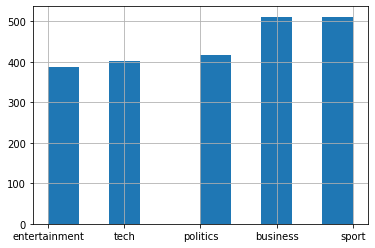

In [5]:
df_all['category'].hist()

In [6]:
to_replace = {'business': 0, 
              'entertainment': 1, 
              'politics': 2, 
              'sport': 3,
              'tech': 4}

labels = ['business', 'entertainment', 'politics', 'sport', 'tech']

df_all.category.replace(to_replace, inplace=True)

## Cross-validation accuracy scores for complete dataset

### Train on Content+Title, Predict on Content+Title

Mean accuracy score: 0.9734831460674156


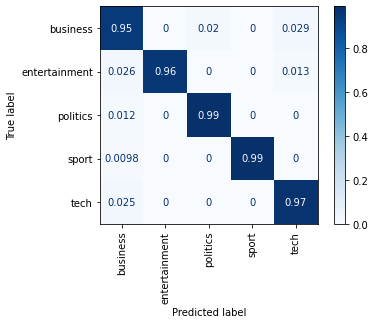

In [9]:
score = []

for iter in range(10): 
    train_idx, test_idx = train_test_split(df_all.index, stratify=df_all.category, test_size=0.2, shuffle=True)

    X_train = []
    for idx in train_idx:
        title = df_all.loc[idx, 'title']
        content = df_all.loc[idx, 'content']
        full_string = title + content
        X_train.append(full_string)
        
    y_train = df_all.loc[train_idx, 'category']

    X_test = []
    for idx in test_idx:
        title = df_all.loc[idx, 'title']
        content = df_all.loc[idx, 'content']
        full_string = title + content
        X_test.append(full_string)
    
    y_test = df_all.loc[test_idx, 'category']

    pipe = Pipeline([('vec', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    score.append(accuracy)
    
#print(score)
print("Mean accuracy score:" , np.mean(score))

_ = plot_confusion_matrix(pipe, X_test, y_test, display_labels=labels, normalize='true', cmap='Blues', xticks_rotation='vertical')

### Train on Content, Predict on Content

Mean accuracy score: 0.9719101123595506


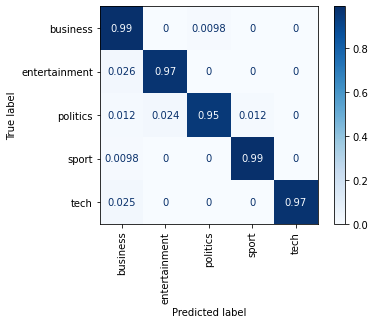

In [149]:
score = []

for iter in range(10): 
    train_idx, test_idx = train_test_split(df_all.index, stratify=df_all.category, test_size=0.2, shuffle=True)

    X_train = df_all.loc[train_idx, 'content']
    y_train = df_all.loc[train_idx, 'category']

    X_test = df_all.loc[test_idx, 'content']
    y_test = df_all.loc[test_idx, 'category']

    pipe = Pipeline([('vec', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    score.append(accuracy)
    
#print(score)
print("Mean accuracy score:" , np.mean(score))

_ = plot_confusion_matrix(pipe, X_test, y_test, display_labels=labels, normalize='true', cmap='Blues', xticks_rotation='vertical')

### Train on Title, Predict on Title

In [150]:
score = []

for iter in range(10): 
    train_idx, test_idx = train_test_split(df_all.index, stratify=df_all.category, test_size=0.2, shuffle=True)

    X_train = df_all.loc[train_idx, 'title']
    y_train = df_all.loc[train_idx, 'category']

    X_test = df_all.loc[test_idx, 'title']
    y_test = df_all.loc[test_idx, 'category']

    pipe = Pipeline([('vec', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    score.append(accuracy)
    
#print(score)
print("Mean accuracy score:" , np.mean(score))


Mean accuracy score: 0.8130337078651685


### Train on Title, Predict on Content

In [151]:
score = []

for iter in range(10): 
    train_idx, test_idx = train_test_split(df_all.index, stratify=df_all.category, test_size=0.2, shuffle=True)

    X_train = df_all.loc[train_idx, 'title']
    y_train = df_all.loc[train_idx, 'category']

    X_test = df_all.loc[test_idx, 'content']
    y_test = df_all.loc[test_idx, 'category']

    pipe = Pipeline([('vec', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    score.append(accuracy)
    
#print(score)
print("Mean accuracy score:" , np.mean(score))


Mean accuracy score: 0.5638202247191011


### Train on Content, Predict on Title

In [152]:
score = []

for iter in range(10): 
    train_idx, test_idx = train_test_split(df_all.index, stratify=df_all.category, test_size=0.2, shuffle=True)

    X_train = df_all.loc[train_idx, 'content']
    y_train = df_all.loc[train_idx, 'category']

    X_test = df_all.loc[test_idx, 'title']
    y_test = df_all.loc[test_idx, 'category']

    pipe = Pipeline([('vec', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    score.append(accuracy)
    
#print(score)
print("Mean accuracy score:" , np.mean(score))


Mean accuracy score: 0.5725842696629213


## Investigating training curves using subsets of the dataset

In [153]:
accuracy_content = []
accuracy_title = []
std_content = []
std_title = []

for n in range(1, 11):
    fraction = n / 10
    subset = df_all.sample(frac=fraction)
    score1 = []
    score2 = []
    for iter in range(10):
        train_idx, test_idx = train_test_split(subset.index, stratify=subset.category, test_size=0.2, shuffle=True)

        X_train1 = subset.loc[train_idx, 'content']
        X_train2 = subset.loc[train_idx, 'title']
        y_train = subset.loc[train_idx, 'category']

        X_test1 = subset.loc[test_idx, 'content']
        X_test2 = subset.loc[test_idx, 'title']
        y_test = subset.loc[test_idx, 'category']

        pipe = Pipeline([('vec', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))])

        pipe.fit(X_train1, y_train)
        y_pred1 = pipe.predict(X_test1)

        accuracy1 = accuracy_score(y_test, y_pred1)
        score1.append(accuracy1) 
        
        pipe = Pipeline([('vec', CountVectorizer()), ('clf', LogisticRegression(max_iter=1000))])

        pipe.fit(X_train2, y_train)
        y_pred2 = pipe.predict(X_test2)

        accuracy2 = accuracy_score(y_test, y_pred2)
        score2.append(accuracy2)
    
    accuracy_content.append(np.mean(score1))
    std_content.append(np.std(score1))
    accuracy_title.append(np.mean(score2))
    std_title.append(np.std(score2))
    

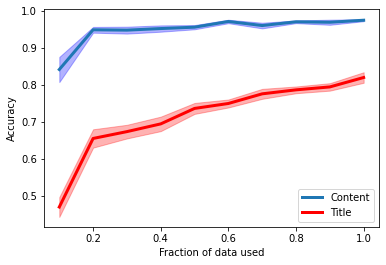

In [154]:
## Reference: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python

ci_content = [] 
ci_title = []

for pos, (elem1, elem2) in enumerate(zip(std_content, std_title)):
    n = ((pos + 1) / 10) * df_all.shape[0]
    n = np.sqrt(10)
    ci_content.append(1.96 * elem1 / n)
    ci_title.append(1.96 * elem2 / n)


plt.plot(np.array(range(1,11)) / 10, accuracy_content, lw = 3, label='Content')
plt.fill_between(np.array(range(1,11)) / 10, np.array(accuracy_content) - np.array(ci_content), np.array(accuracy_content) + np.array(ci_content), color='b', alpha=0.3)
plt.plot(np.array(range(1,11)) / 10, accuracy_title, 'r', lw = 3, label='Title')
plt.fill_between(np.array(range(1,11)) / 10, np.array(accuracy_title) - np.array(ci_title), np.array(accuracy_title) + np.array(ci_title), color='r', alpha=0.3)
plt.xlabel('Fraction of data used')
plt.ylabel('Accuracy')
_ = plt.legend()

# Applying Dimensionality Reduction, using TSNE, followed by Classification

See [reference](https://www.kaggle.com/bbose71/bbc-news-classification)

In [48]:
print(to_replace)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [12]:
reverse_dict = {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [32]:
subset = df_all.sample(frac=1)
vec = TfidfVectorizer()
raw_features = vec.fit_transform(subset.content)
projected_features = TSNE(n_components=2).fit_transform(raw_features)

In [53]:
sns_data = pd.DataFrame(np.hstack([projected_features, subset[['category']]]))
sns_data.columns = ['feature0', 'feature1', 'category']
sns_data.replace(reverse_dict, inplace=True)
sns_data.head()

,feature0,feature1,category
0,-16.812731,-1.263376,tech
1,-13.666121,8.959361,tech
2,20.619707,-25.524290,politics
3,-1.134838,-35.238838,politics
4,-12.613757,12.337928,tech


<AxesSubplot:xlabel='feature0', ylabel='feature1'>

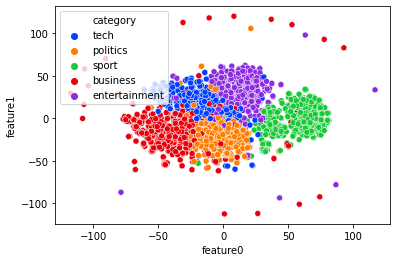

In [54]:
sns.scatterplot(data=sns_data, x='feature0', y='feature1', hue='category', palette='bright')

In [27]:
def tsne_followed_by_classification(clf):

    score = []

    for iter in range(10): 
        train_idx, test_idx = train_test_split(df_all.index, stratify=df_all.category, test_size=0.2, shuffle=True)

        X_train = df_all.loc[train_idx, 'content']
        y_train = df_all.loc[train_idx, 'category']

        X_test = df_all.loc[test_idx, 'content']
        y_test = df_all.loc[test_idx, 'category']


        vec = TfidfVectorizer()
        raw_features_train = vec.fit_transform(X_train)
        raw_features_test = vec.transform(X_test)

        tsne = TSNE(n_components=2)
        projected_features = tsne.fit_transform(scipy.sparse.vstack([raw_features_train, raw_features_test]))
        projected_features_train = projected_features[:raw_features_train.shape[0]]
        projected_features_test = projected_features[raw_features_train.shape[0]:]

        if iter == 9:
            plt.subplot(121)
            plt.scatter(projected_features_train[:,0], projected_features_train[:,1], s=5, c=y_train, alpha=1.0)
            plt.xlabel('Training Data')
            plt.subplot(122)
            plt.scatter(projected_features_test[:,0], projected_features_test[:,1], s=5, c=y_test, alpha=1.0)
            plt.xlabel('Test Data')

        clf = clf
        clf.fit(projected_features_train, y_train)

        y_pred = clf.predict(projected_features_test)

        accuracy = accuracy_score(y_test, y_pred)
        score.append(accuracy)

    print("Mean accuracy score:" , np.mean(score))

    fig = plt.figure()
    _ = plot_confusion_matrix(clf, projected_features_test, y_test, display_labels=labels, normalize='true', cmap='Blues', xticks_rotation='vertical')

### Using Logistic Regression Classifier 

Mean accuracy score: 0.8887640449438201


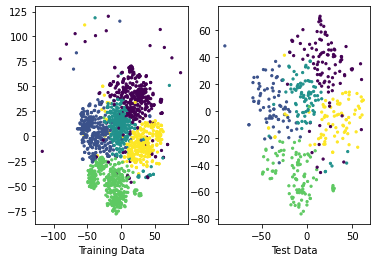

<Figure size 432x288 with 0 Axes>

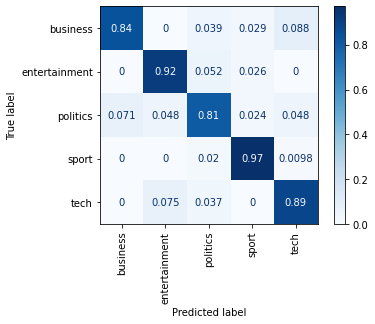

In [23]:
tsne_followed_by_classification(clf = LogisticRegression(max_iter=1000))

### Using Support Vector Classifier with Radial Basis Kernel 

Mean accuracy score: 0.9053932584269662


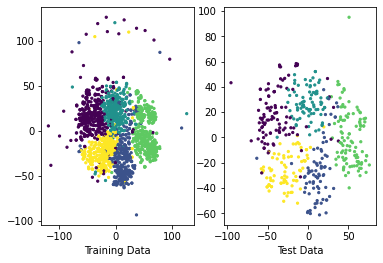

<Figure size 432x288 with 0 Axes>

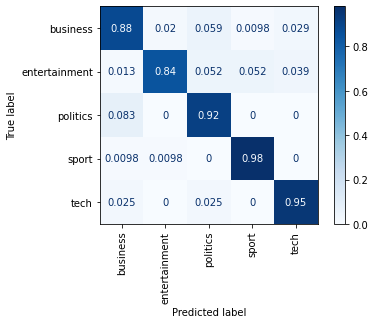

In [24]:
tsne_followed_by_classification(clf = SVC())

### Using K Nearest Neighbor Classifier 

Mean accuracy score: 0.9206741573033709


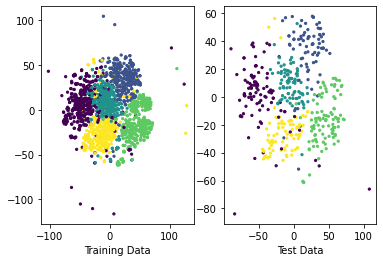

<Figure size 432x288 with 0 Axes>

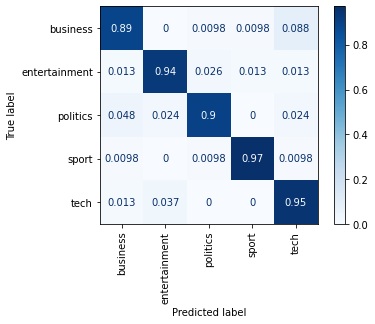

In [25]:
tsne_followed_by_classification(clf = KNeighborsClassifier())

# Generating word clouds based on chi2 correlations of words with topics

See [reference](https://www.kaggle.com/bbose71/bbc-news-classification) and [reference](https://stackoverflow.com/questions/45588724/generating-word-cloud-for-items-in-a-list-in-python)

In [58]:
print(to_replace)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [59]:
subset = df_all.sample(frac=1)
vec = TfidfVectorizer()
raw_features = vec.fit_transform(subset.content)

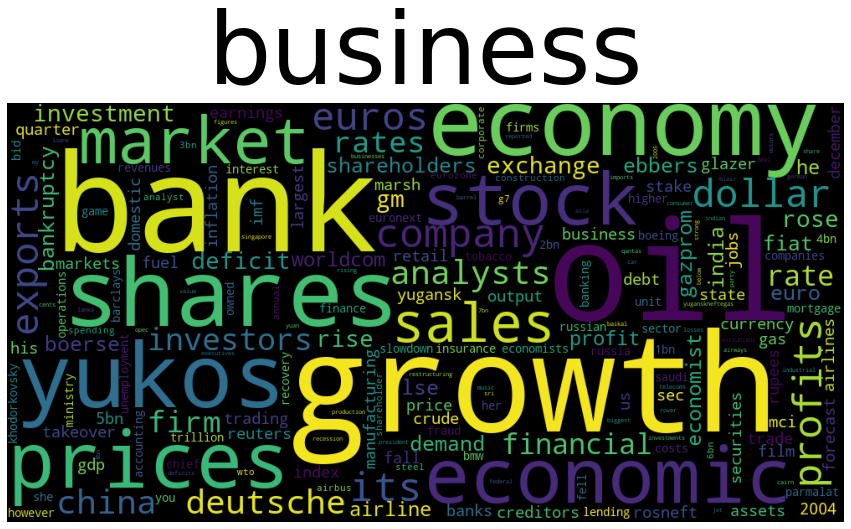

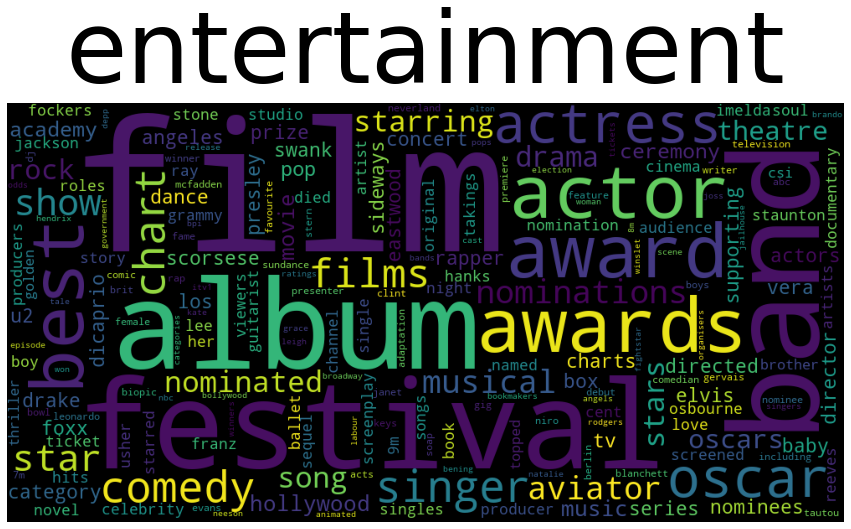

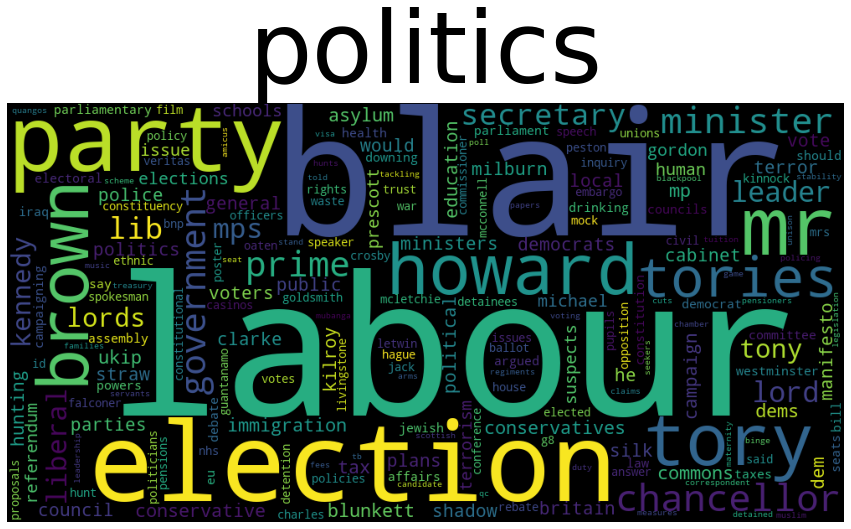

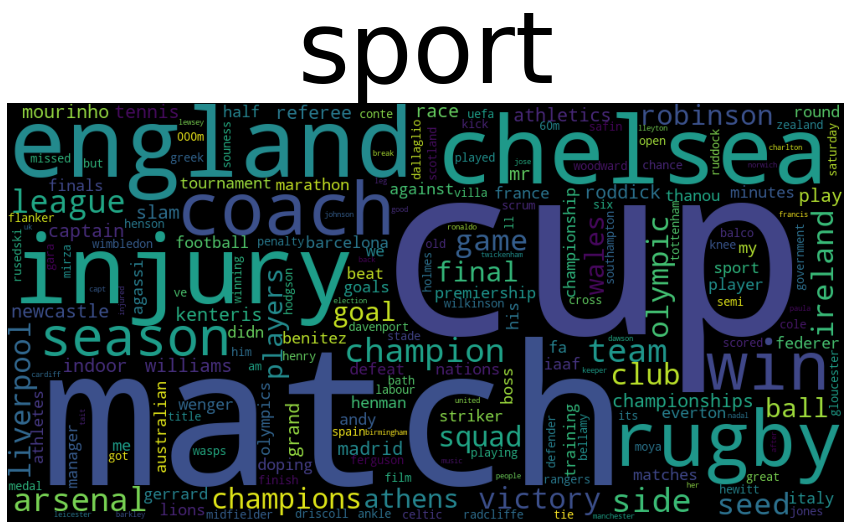

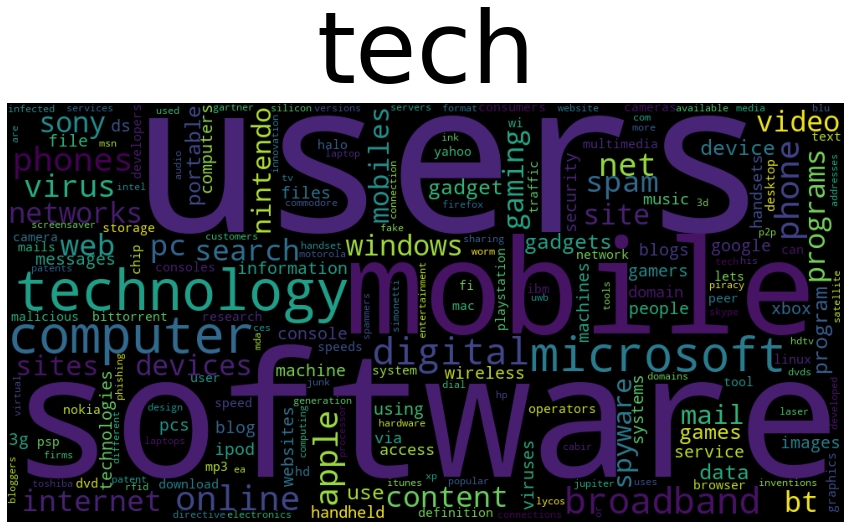

In [68]:
dd = {} 

for k, v in to_replace.items():
    features_chi2 = chi2(raw_features, subset['category']==v)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vec.get_feature_names())[indices]
    sorted_features_chi2 = np.array(features_chi2[0])[indices]
    for word, chi_value in zip(feature_names, sorted_features_chi2):
        dd[word] = chi_value 
    word_cloud_dict=dd
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.title(k, fontsize=100)
    plt.axis("off")

# Applying Clustering

In [13]:
reverse_dict = {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [7]:
subset = df_all.sample(frac=1)
vec = TfidfVectorizer()
raw_features = vec.fit_transform(subset.content)
projected_features = TSNE(n_components=2).fit_transform(raw_features)
X = raw_features.todense()

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

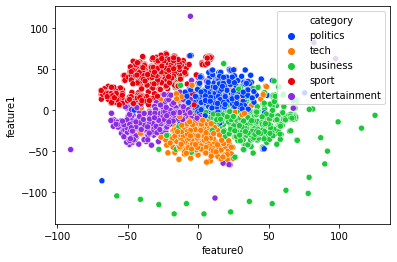

In [15]:
sns_data_1 = pd.DataFrame(np.hstack([projected_features, subset[['category']]]))
sns_data_1.columns = ['feature0', 'feature1', 'category']
sns_data_1.replace(reverse_dict, inplace=True)
sns.scatterplot(data=sns_data_1, x='feature0', y='feature1', hue='category', palette='bright')

## Hierarchical Clustering based on Cosine Similarity 

See [reference](https://datascience.stackexchange.com/questions/22828/clustering-with-cosine-similarity) and [reference](https://www.kaggle.com/gabnaressi/bbc-news-text-clustering)

In [29]:
#threshold = 0.9
Z = hierarchy.linkage(X, "average", metric="cosine")
C = hierarchy.fcluster(Z, t=5, criterion="maxclust")

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

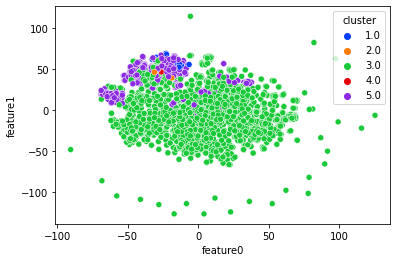

In [20]:
sns_data_2 = pd.DataFrame(np.hstack([projected_features, np.expand_dims(C, -1)]))
sns_data_2.columns = ['feature0', 'feature1', 'cluster']
#sns_data_2.replace(reverse_dict, inplace=True)
sns.scatterplot(data=sns_data_2, x='feature0', y='feature1', hue='cluster', palette='bright')

## K-Means Clustering based on Cosine Similarity 

See [reference](https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python), [reference](https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans), and [reference](https://www.kaggle.com/gabnaressi/bbc-news-text-clustering)

In [57]:
X_Norm = preprocessing.normalize(raw_features)
km2 = cluster.KMeans(n_clusters=5, random_state=45).fit(X_Norm)
labels = km2.labels_

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

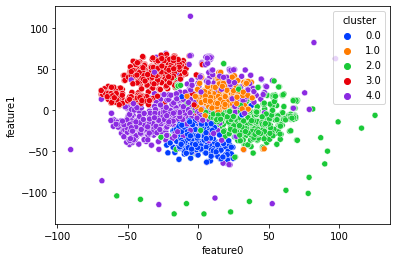

In [58]:
sns_data_3 = pd.DataFrame(np.hstack([projected_features, np.expand_dims(labels, -1)]))
sns_data_3.columns = ['feature0', 'feature1', 'cluster']
#sns_data_2.replace(reverse_dict, inplace=True)
sns.scatterplot(data=sns_data_3, x='feature0', y='feature1', hue='cluster', palette='bright')